# Classifier

1. Logistic regression (https://www.datacamp.com/community/tutorials/understanding-logistic-regression-python)


functions:
https://scikit-learn.org/stable/modules/feature_selection.html

example:
https://scikit-learn.org/stable/auto_examples/feature_selection/plot_feature_selection.html#sphx-glr-auto-examples-feature-selection-plot-feature-selection-py

tut:
https://medium.com/@GouthamPeri/pipeline-with-tuning-scikit-learn-b2789dca9dc2

https://stackoverflow.com/questions/33376078/python-feature-selection-in-pipeline-how-determine-feature-names

## Import packages

In [1]:
import pandas as pd
from tqdm.notebook import tqdm
import random
random.seed(32)
import sklearn
# from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Import data

In [2]:
df = pd.read_pickle("wordlists_lin_feat_df_withoutuserfeat_allcomments.pkl")
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1606 entries, -Areopagan- to zyzee
Columns: 103888 entries, body to mrc_pmean
dtypes: float64(87790), int64(16092), object(6)
memory usage: 1.2+ GB


In [3]:
predictors = df.columns.tolist()
i = 0
predictorsfile=open('predictorslist.txt','w')
# predictorsfile.writelines(predictors)
for element in predictors:
    predictorsfile.write(str(i))
    predictorsfile.write(" ")
    predictorsfile.write(element)
    predictorsfile.write('\n')
    i+=1
predictorsfile.close()

In [4]:
# multilevel columns

lst1 = (15)*["data"]
lst2 = (20-16)*["global"]
lst3 = (44-20)*["time"]
lst4 = (16102-44)*["subreddits"]
lst5 = (16115-16102)*["extra_features"]
lst6 = (96307-16115)*["word_ngrams"]
lst7 = (103828-96307)*["char_ngrams"]
lst8 = (103889-103828)*["wordlists"]
headers = lst1 + lst2 + lst3 + lst4 +lst5 + lst6 + lst7 + lst8
columns = df.columns.values
print(len(headers))
print(len(columns))
arrays = [headers] + [columns]
df.columns=pd.MultiIndex.from_arrays(arrays)
df

103888
103888


data  \
                                                           body   
author                                                            
-Areopagan-   Your first and second question is the same que...   
-BigSexy-     I've been asked to cum everywhere with my ex j...   
-BlitzN9ne    I'm currently in the middle of making a Payday...   
-CrestiaBell  First and foremost I extend my condolences to ...   
-dyad-        I failed both...I'm great at reading people ir...   
...                                                         ...   
zugzwang_03   You know that giggly group of women going to t...   
zuluthrone    I saw some speculate that the "download" would...   
zwelg         I am actually pretty pleased about my score:Ag...   
zymmaster     Respectfully disagree. Offense had plenty of i...   
zyzee         Tarzaned can't be compared in this situation. ...   

                                                                 \
                                                       doc_body   
author                                                            
-Areopagan-   [Your first and second question is the same qu...   
-BigSexy-     [I've been asked to cum everywhere with my ex ...   
-BlitzN9ne    [I'm currently in the middle of making a Payda...   
-CrestiaBell  [First and foremost I extend my condolences to...   
-dyad-        [I failed both...I'm great at reading people i...   
...                                                         ...   
zugzwang_03   [You know that giggly group of women going to ...   
zuluthrone    [I saw some speculate that the "download" woul...   
zwelg         [I am actually pretty pleased about my score:A...   
zymmaster     [Respectfully disagree. Offense had plenty of ...   
zyzee         [Tarzaned can't be compared in this situation....   

                                                                 \
                                                        probody   
author                                                            
-Areopagan-   [first second question question try make incis...   
-BigSexy-     [asked cum everywhere ex experiment preferred ...   
-BlitzN9ne    [currently middle making payday two inspired m...   
-CrestiaBell  [first foremost extend condolences family espe...   
-dyad-        [failed great reading people irl swear haha, i...   
...                                                         ...   
zugzwang_03   [know giggly group women going bar go dance sa...   
zuluthrone    [saw speculate download would backup rather st...   
zwelg         [actually pretty pleased score agreeableness m...   
zymmaster     [respectfully disagree offense plenty issues s...   
zyzee         [tarzaned not compared situation not pro playe...   

                                                                 \
                                                         tokens   
author                                                            
-Areopagan-   [[first, second, question, question, try, make...   
-BigSexy-     [[asked, cum, everywhere, ex, experiment, pref...   
-BlitzN9ne    [[currently, middle, making, payday, two, insp...   
-CrestiaBell  [[first, foremost, extend, condolences, family...   
-dyad-        [[failed, great, reading, people, irl, swear, ...   
...                                                         ...   
zugzwang_03   [[know, giggly, group, women, going, bar, go, ...   
zuluthrone    [[saw, speculate, download, would, backup, rat...   
zwelg         [[actually, pretty, pleased, score, agreeablen...   
zymmaster     [[respectfully, disagree, offense, plenty, iss...   
zyzee         [[tarzaned, not, compared, situation, not, pro...   

                                                                               \
                                                     senttokens agreeableness   
author                                                                          
-Areopagan-   [[Your first and second question is the same q

In [5]:
df['data', 'agree5'] = df['data', 'agreeableness'].apply(lambda x: 0 if x<20 else(1 if x>19 and x<40 else(2 if x>39 and x<60 else(3 if x>59 and x<80 else 4))))
df['data', 'openn5'] = df['data', 'openness'].apply(lambda x: 0 if x<20 else(1 if x>19 and x<40 else(2 if x>39 and x<60 else(3 if x>59 and x<80 else 4))))
df['data', 'consc5'] = df['data', 'conscientiousness'].apply(lambda x: 0 if x<20 else(1 if x>19 and x<40 else(2 if x>39 and x<60 else(3 if x>59 and x<80 else 4))))
df['data', 'extra5'] = df['data', 'extraversion'].apply(lambda x: 0 if x<20 else(1 if x>19 and x<40 else(2 if x>39 and x<60 else(3 if x>59 and x<80 else 4))))
df['data', 'neuro5'] = df['data', 'neuroticism'].apply(lambda x: 0 if x<20 else(1 if x>19 and x<40 else(2 if x>39 and x<60 else(3 if x>59 and x<80 else 4))))

In [6]:
n_bins = 20

def hist_true(df, trait):
    fig, ax = plt.subplots()
    plt.hist(df[trait], bins = 20)
    plt.title(trait, y=1.1)
    plt.xlabel("score")

# hist_true(df, "openn")

def all_hist_true(df):
    plt.figure(figsize = (16, 16))
#     plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
    plt.subplot(3, 2, 1)
    plt.hist(df['data', 'agreeableness'], bins = 20)
    plt.title('Agreeableness')
    
    plt.subplot(3, 2, 2)
    plt.hist(df['data', 'openness'], bins = 20)
    plt.title('Openness')
    
    plt.subplot(3, 2, 3)
    plt.hist(df['data', 'conscientiousness'], bins = 20)
    plt.title('Conscientiousness')
    
    plt.subplot(3, 2, 4)
    plt.hist(df['data', 'extraversion'], bins = 20)
    plt.title('Extraversion')
    
    plt.subplot(3, 2, 5)
    plt.hist(df['data', 'neuroticism'], bins = 20)
    plt.title('Neuroticism')
    
    plt.suptitle("Histograms of the true trait values")
    plt.subplots_adjust(left=0.1, 
                    bottom=0.1,  
                    right=0.9,  
                    top=0.9,  
                    wspace=0.4,  
                    hspace=0.4) 
    plt.show()


## Trait

In [7]:
#split dataset in features and target variable depending on which trait to focus on
def trait(df, classes, trait_name, startnumber):
    featurelist = df.columns.tolist()
    feature_cols = featurelist[startnumber:]
#     print(len(feature_cols))
    x = df[feature_cols] 
    if classes=='binary':
    
        if trait_name == 'agreeableness':
            y = df['data', 'agree']
        elif trait_name == 'openness':
            y = df['data', 'openn']
        elif trait_name == 'conscientiousness':
            y = df['data', 'consc']
        elif trait_name == 'extraversion':
            y = df['data', 'extra']
        elif trait_name == 'neuroticism':
            y = df['data', 'neuro']   
    else:
        if trait_name == 'agreeableness':
            y = df['data', 'agree5']
        elif trait_name == 'openness':
            y = df['data', 'openn5']
        elif trait_name == 'conscientiousness':
            y = df['data', 'consc5']
        elif trait_name == 'extraversion':
            y = df['data', 'extra5']
        elif trait_name == 'neuroticism':
            y = df['data', 'neuro5'] 
    return x,y 

## Classifier

1. Logistic regression

In [8]:
def logclassifier(x_train,y_train, x_test):
    # instantiate the model (using the default parameters)
    logreg = LogisticRegression()
    # fit the model with data
    logreg.fit(x_train,y_train)
#     y_pred=logreg.predict(x_test)    
    return logreg

# logreg = logclassifier(x_train,y_train, x_test)
# y_pred=logreg.predict(x_test)



# ANOVA feature selection for numeric input and categorical output

def create_pipeline(x_train, y_train, classifier, num_feat):
    if classifier == "log":
        pipeline = Pipeline([
          ('variance_threshold', VarianceThreshold()),
          ('feature_selection',  SelectKBest(f_classif, k=num_feat)),
          ('scaler', StandardScaler()),
          ('classification', LogisticRegression(n_jobs=-1))
        ])
    elif classifier == "multilog":
        pipeline = Pipeline([
          ('variance_threshold', VarianceThreshold()),
          ('feature_selection',  SelectKBest(f_classif, k=num_feat)),
          ('scaler', StandardScaler()),
          ('classification', LogisticRegression(multi_class='ovr', solver='liblinear', n_jobs=-1))
        ])
        
    pipeline.fit(x_train, y_train)
    return pipeline





# logpipe = create_pipeline('log')
# y_pred=logpipe.predict(x_test)

# print("shape of x before feature selection", x.shape)
# x_new = SelectKBest(f_classif, k=30).fit_transform(x, y)
# print("shape of x after feature selection", x_new.shape)

## Get names of 30 most important features

In [9]:
# get names of the features
def get_names(x, pipeline):
    features = pipeline.named_steps['feature_selection']
    names = x.columns[features.get_support(indices=True)]
    return names
# names = get_names(logpipe)
# print(names)

### Get p-values

In [10]:
def get_pvalues(pipeline, x):
#     x_indices = np.arange(x.shape[-1])
#     selector = SelectKBest(f_classif, k=30)
#     selector.fit(x_train, y_train)
#     scores = -np.log10(selector.pvalues_)
    features = pipeline.named_steps['feature_selection']
    pvalues = features.pvalues_
#     pvalues /= pvalues.max()
    dfpvalues = pd.DataFrame(features.pvalues_)
    dfscores = pd.DataFrame(features.scores_)
    dfcolumns = pd.DataFrame(x.columns)
    #concat two dataframes for better visualization 
    featureScores = pd.concat([dfcolumns,dfscores, dfpvalues],axis=1)
    featureScores.columns = ['specs','score', 'pvalue']
    featureScores.sort_values(by='pvalue')

    plt.figure(figsize = (12, 4))
    plt.subplot(1, 2, 1)
    plt.hist(pvalues, bins=20)
    plt.title('All p-values')
    plt.subplot(1, 2, 2)
    smallpvalues = pvalues[pvalues<0.1]
    plt.hist(smallpvalues, bins=10)
    plt.title('Small p-values')
    
    plt.suptitle("Histograms of the p-values")
    plt.subplots_adjust(left=0.1, 
                    bottom=0.1,  
                    right=0.9,  
                    top=0.9,  
                    wspace=0.4,  
                    hspace=0.4) 
    plt.show()
    
    return featureScores

## Scores

In [11]:
def scores(y_test, y_pred, presentationtype):
    
    if presentationtype == "scores":
        accuracy=metrics.accuracy_score(y_test, y_pred)
        precision=metrics.precision_score(y_test, y_pred)
        recall=metrics.recall_score(y_test, y_pred)
        f_one=metrics.f1_score(y_test, y_pred)
        return accuracy, precision, recall, f_one
    if presentationtype == "report":
        report = classification_report(y_test, y_pred)
        return report


def score_plot(logreg, y_test, x_test):
    lr_probs = logreg.predict_proba(x_test)
    # keep probabilities for the positive outcome only
    lr_probs = lr_probs[:, 1]
    # predict class values
#     yhat = logreg.predict(x_test)
    lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)
#     lr_f1, lr_auc = f1_score(y_test, yhat), auc(lr_recall, lr_precision)

    # plot the precision-recall curves
    no_skill = len(y_test[y_test==1]) / len(y_test)
    fig, ax = plt.subplots()
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
    plt.plot(lr_recall, lr_precision, marker='.', label='Classifier')
    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # show the legend
    plt.legend()
    plt.show()
    
    return lr_precision, lr_recall


### Score plot
Smaller values on the x-axis of the plot indicate lower false positives and higher true negatives.


Larger values on the y-axis of the plot indicate higher true positives and lower false negatives.

## Create and print confusion matrix

In [12]:
def create_cnfmatrix(y_test, y_pred, plotting=True):
    cnfpipe_matrix = metrics.confusion_matrix(y_test, y_pred)
#     print(cnfpipe_matrix)
#     disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cnfpipe_matrix)
#     disp.plot() 
    tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred).ravel()
    sumpositive = tp + fn
    sumnegative = fp + tn
    sumcorrect = tp + tn
    sumwrong = fp + fn
    sumall = tn+fp+fn+tp
    print("TN, FP, FN, TP: ", tn, fp, fn, tp, "\nSum: ", sumall, "\nSum correct predictions: ", 
          sumcorrect, "Percent: ", sumcorrect/sumall, "\nSum wrong predictions: ", sumwrong, "\tPercent: ",
          sumwrong/sumall, "\nSum actual positives: ", sumpositive, "\tPercent: ", sumpositive/sumall,
          "\nSum actual negatives: ", sumnegative, "\tPercent: ", sumnegative/sumall)
    
    if plotting:
        %matplotlib inline
        class_names=[0,1] # name  of classes
        fig, ax = plt.subplots()
        tick_marks = np.arange(len(class_names))
        plt.xticks(tick_marks, class_names)
        plt.yticks(tick_marks, class_names)
        # create heatmap
        sns.heatmap(pd.DataFrame(cnfpipe_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
        ax.xaxis.set_label_position("bottom")
        plt.tight_layout()
        plt.title('Confusion matrix', y=1.1)
        plt.ylabel('Actual label')
        plt.xlabel('Predicted label')
        plt.show()
        
# cnfmatrix = create_cnfmatrix(y_test, y_pred, True)

# Wrapper

In [13]:
traits = ['openness', 'conscientiousness', 'extraversion', 'agreeableness', 'neuroticism']

def switching(trait):
    switcher={
            'openness':30,
            'conscientiousness':30,
            'agreeableness':30,
            'extraversion':30,
            'neuroticism':30
         }
    return switcher.get(trait,"Invalid")

def classify(df, classes, plotting=True):
    startnumber = 18
    for trait_name in traits:
        num_feat = switching(trait_name)
        print("Trait to predict: ", trait_name)
        if classes == 'binary':
            x,y = trait(df, 'binary',trait_name, startnumber)
        else:
            x,y = trait(df, 'multi', trait_name, startnumber)
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=0)
        print("Number of authors in y_train: ", len(y_train))
        print("Number of authors in y_test: ", len(y_test))
        logpipe = create_pipeline(x_train, y_train, 'log', num_feat)
        y_pred=logpipe.predict(x_test)
        print("Number of authors in y_pred: ", len(y_pred))
        names = get_names(x, logpipe)
        print("Names of the top", len(names), "features: \n", names, "\n")
        pvalues = get_pvalues(logpipe, x)
    #     print("p-values of", len(pvalues), "features: \n", pvalues, "\n")
        if trait_name=="openness":
            count = pvalues['pvalue'].le(0.02).sum()
        if trait_name=="conscientiousness":
            count = pvalues['pvalue'].le(0.07).sum()
        if trait_name=="extraversion":
            count = pvalues['pvalue'].le(0.05).sum()
        if trait_name=="agreeableness":
            count = pvalues['pvalue'].le(0.04).sum()
        if trait_name=="neuroticism":
            count = pvalues['pvalue'].le(0.04).sum()
        print("Number of features with this threshold: ", count)
#         print("\nP-Values: \nNumber of features: ", 30)
#         print(pvalues.nsmallest(count,'pvalue'))
        print("\n")
        report = scores(y_test, y_pred, "report")
        print("Classification report: \n", report)
        if classes == 'binary':
            cnfmatrix = create_cnfmatrix(y_test, y_pred, plotting=True) 
    #     accuracy, precision, recall, f_one = scores(y_test, y_pred, "scores")
    #     print("Scores:\nAccuracy:",accuracy, "\nPrecision:",precision, "\nRecall:",recall, "\nF1 score:",f_one)
            lr_precision, lr_recall = score_plot(logpipe, y_test, x_test)
    #     print("Scores:\nLR_Precision:",lr_precision, "\nLR_Recall:",lr_recall)

# startnumber ngrams : 36
# startnumber wordlists: 29
# startnumber: linguistic features: 30
# startnumber: authorversion with arrays in user features: 26
# startnumber: final version 18
# start = 18

## Histogram of true traits

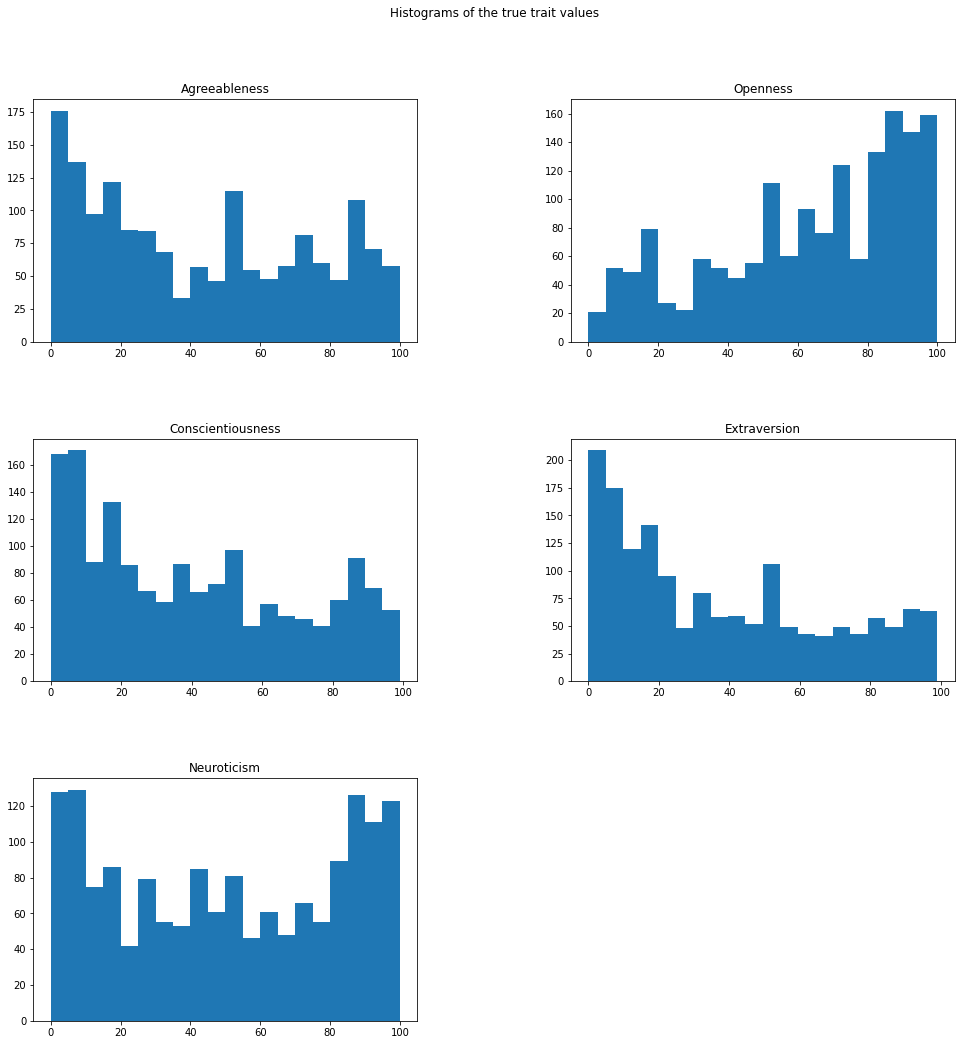

In [14]:
# true histogram plots
all_hist_true(df)

In [15]:
# %%javascript
# IPython.OutputArea.auto_scroll_threshold = 1000;

## Test set: binary outcome

Y is binary: 

Trait to predict:  openness
Number of authors in y_train:  1204
Number of authors in y_test:  402


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:78: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:86: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


Number of authors in y_pred:  402
Names of the top 30 features: 
 MultiIndex([('subreddits',      'taylorswiftbum'),
            ('subreddits',        'colonizemars'),
            ('subreddits',      'incelsgonewild'),
            ('subreddits',           'xsomalian'),
            ('subreddits',     'choose_your_own'),
            ('subreddits',            'calmdown'),
            ('subreddits',         'pharahmains'),
            ('subreddits',            'polyglot'),
            ('subreddits',             'scratch'),
            ('subreddits',              'techno'),
            ('subreddits',       'manyatruenerd'),
            ('subreddits',       'youshouldknow'),
            ('subreddits',          'pussymound'),
            ('subreddits',         'pipetobacco'),
            ('subreddits',    'perfect_response'),
            ('subreddits',            'winnipeg'),
            ('subreddits',           'nightwish'),
            ('subreddits', 'minecraftcirclejerk'),
            ('su

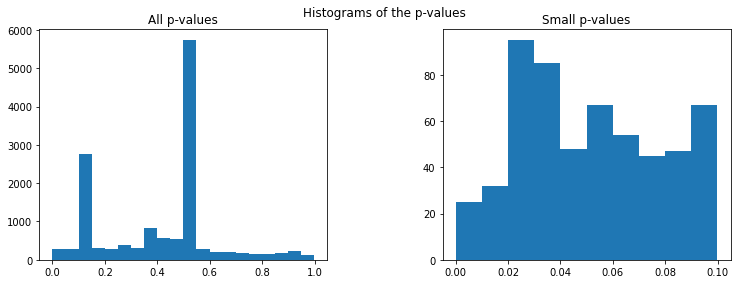

Number of features with this threshold:  57


Classification report: 
               precision    recall  f1-score   support

           0       0.91      0.76      0.83       105
           1       0.92      0.97      0.95       297

    accuracy                           0.92       402
   macro avg       0.91      0.87      0.89       402
weighted avg       0.92      0.92      0.92       402

TN, FP, FN, TP:  80 25 8 289 
Sum:  402 
Sum correct predictions:  369 Percent:  0.917910447761194 
Sum wrong predictions:  33 	Percent:  0.08208955223880597 
Sum actual positives:  297 	Percent:  0.7388059701492538 
Sum actual negatives:  105 	Percent:  0.26119402985074625


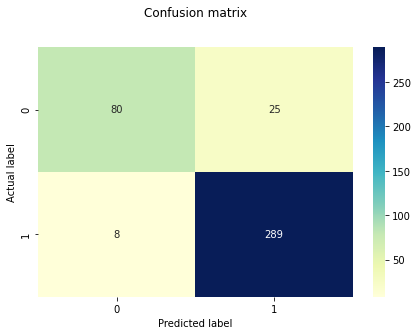

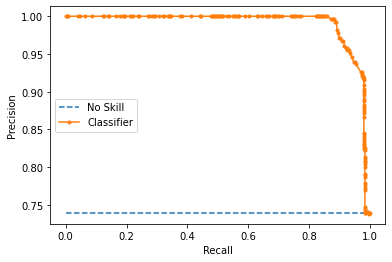

Trait to predict:  conscientiousness
Number of authors in y_train:  1204
Number of authors in y_test:  402


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:78: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:86: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


Number of authors in y_pred:  402
Names of the top 30 features: 
 MultiIndex([(      'time',           'friday'),
            (      'time',            'march'),
            (      'time',             'june'),
            (      'time',         'november'),
            (      'time',             '2017'),
            ('subreddits',         'cyberdom'),
            ('subreddits',             'anno'),
            ('subreddits',       'astro_kpop'),
            ('subreddits',              'tfc'),
            ('subreddits',      'bimbofetish'),
            ('subreddits',            'ecchi'),
            ('subreddits',         'roadporn'),
            ('subreddits',        'roastmeta'),
            ('subreddits',   'warframerunway'),
            ('subreddits',             'nova'),
            ('subreddits',     'allthingsmlg'),
            ('subreddits',       'floridaman'),
            ('subreddits',    'oliverfrancis'),
            ('subreddits',            'motog'),
            ('subreddi

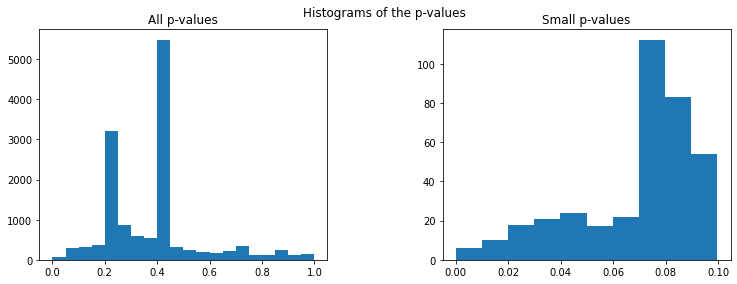

Number of features with this threshold:  118


Classification report: 
               precision    recall  f1-score   support

           0       0.91      0.93      0.92       251
           1       0.88      0.84      0.86       151

    accuracy                           0.90       402
   macro avg       0.89      0.89      0.89       402
weighted avg       0.90      0.90      0.90       402

TN, FP, FN, TP:  234 17 24 127 
Sum:  402 
Sum correct predictions:  361 Percent:  0.8980099502487562 
Sum wrong predictions:  41 	Percent:  0.10199004975124377 
Sum actual positives:  151 	Percent:  0.3756218905472637 
Sum actual negatives:  251 	Percent:  0.6243781094527363


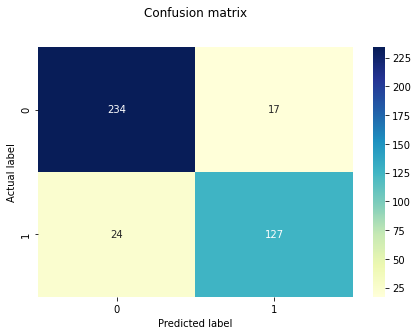

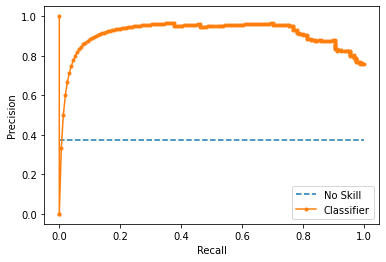

Trait to predict:  extraversion
Number of authors in y_train:  1204
Number of authors in y_test:  402


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:78: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:86: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


Number of authors in y_pred:  402
Names of the top 30 features: 
 MultiIndex([('subreddits',             'aram'),
            ('subreddits',       'astro_kpop'),
            ('subreddits',      'politicsnow'),
            ('subreddits',      'goldenkamuy'),
            ('subreddits',  'theexaminedlife'),
            ('subreddits',          'newgirl'),
            ('subreddits',        'stretched'),
            ('subreddits',      'learncsharp'),
            ('subreddits',        'studioone'),
            ('subreddits',        'pokememes'),
            ('subreddits',   'bigtiddygothgf'),
            ('subreddits',             'mepl'),
            ('subreddits',     'christianr4r'),
            ('subreddits',      'ridiebridie'),
            ('subreddits',          'ableton'),
            ('subreddits',  'oopsdidntmeanto'),
            ('subreddits',            'motog'),
            ('subreddits',   'psych_religion'),
            ('subreddits',              'ubc'),
            ('subreddi

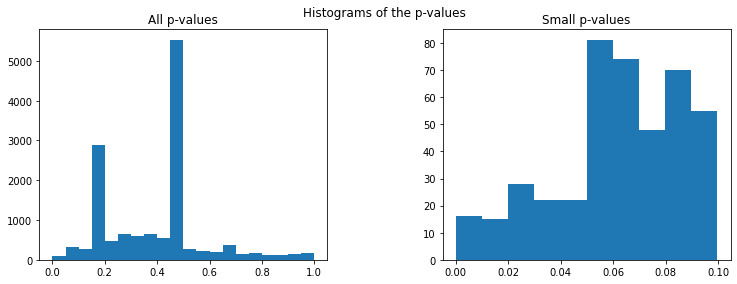

Number of features with this threshold:  104


Classification report: 
               precision    recall  f1-score   support

           0       0.95      0.95      0.95       258
           1       0.91      0.90      0.91       144

    accuracy                           0.93       402
   macro avg       0.93      0.93      0.93       402
weighted avg       0.93      0.93      0.93       402

TN, FP, FN, TP:  245 13 14 130 
Sum:  402 
Sum correct predictions:  375 Percent:  0.9328358208955224 
Sum wrong predictions:  27 	Percent:  0.06716417910447761 
Sum actual positives:  144 	Percent:  0.3582089552238806 
Sum actual negatives:  258 	Percent:  0.6417910447761194


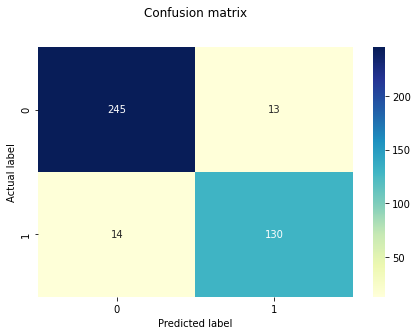

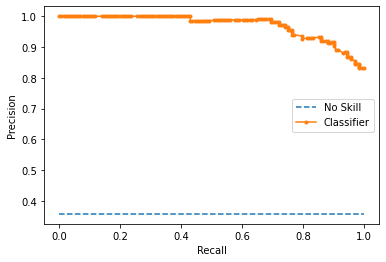

Trait to predict:  agreeableness
Number of authors in y_train:  1204
Number of authors in y_test:  402


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:78: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:86: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


Number of authors in y_pred:  402
Names of the top 30 features: 
 MultiIndex([('subreddits',                'aram'),
            ('subreddits',        'xntxpolitics'),
            ('subreddits',       'healthanxiety'),
            ('subreddits',          'brainmemes'),
            ('subreddits',   'legendsoftomorrow'),
            ('subreddits',     'hmusfederalists'),
            ('subreddits',     'mhoclabourpress'),
            ('subreddits',                 'jhu'),
            ('subreddits',        'donaldglover'),
            ('subreddits',           'berlindnd'),
            ('subreddits',                'meup'),
            ('subreddits',     'notthebeaverton'),
            ('subreddits',     'ironfistnetflix'),
            ('subreddits',                'cern'),
            ('subreddits',            'celebsbr'),
            ('subreddits',                'beer'),
            ('subreddits',            'toukiden'),
            ('subreddits',        'youtubemusic'),
            ('su

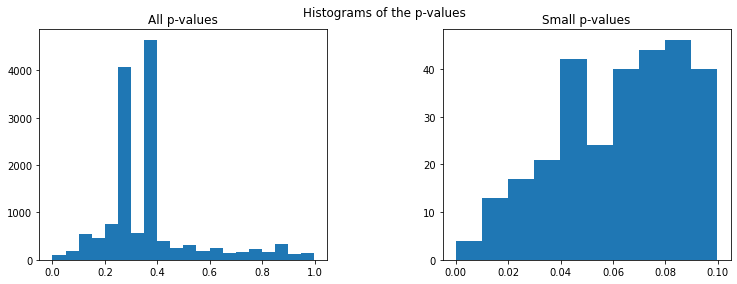

Number of features with this threshold:  55


Classification report: 
               precision    recall  f1-score   support

           0       0.99      0.87      0.92       225
           1       0.85      0.99      0.92       177

    accuracy                           0.92       402
   macro avg       0.92      0.93      0.92       402
weighted avg       0.93      0.92      0.92       402

TN, FP, FN, TP:  195 30 2 175 
Sum:  402 
Sum correct predictions:  370 Percent:  0.9203980099502488 
Sum wrong predictions:  32 	Percent:  0.07960199004975124 
Sum actual positives:  177 	Percent:  0.44029850746268656 
Sum actual negatives:  225 	Percent:  0.5597014925373134


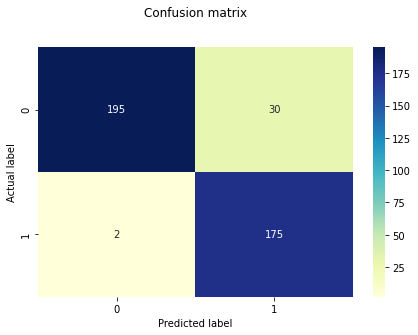

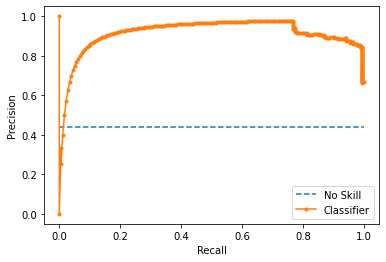

Trait to predict:  neuroticism
Number of authors in y_train:  1204
Number of authors in y_test:  402


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:78: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:86: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


Number of authors in y_pred:  402
Names of the top 30 features: 
 MultiIndex([('subreddits',             'hammer'),
            ('subreddits',        'rightwinguk'),
            ('subreddits', 'smallpenisproblems'),
            ('subreddits',            'actuary'),
            ('subreddits',                'dae'),
            ('subreddits',                'm43'),
            ('subreddits',       'thegoodplace'),
            ('subreddits',                'gog'),
            ('subreddits',         'amumumains'),
            ('subreddits',    'mammothmountain'),
            ('subreddits',                'dsp'),
            ('subreddits',            'riseupp'),
            ('subreddits',              'bacon'),
            ('subreddits', 'thegreatwarchannel'),
            ('subreddits',            'iconsgg'),
            ('subreddits',  'writingcirclejerk'),
            ('subreddits', 'asianparentstories'),
            ('subreddits',      'pokemongonova'),
            ('subreddits',        

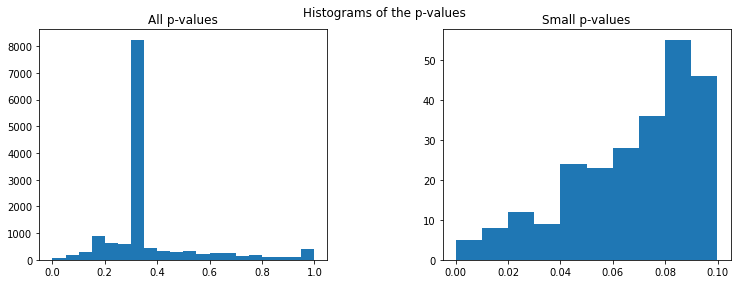

Number of features with this threshold:  35


Classification report: 
               precision    recall  f1-score   support

           0       0.87      0.90      0.89       201
           1       0.90      0.87      0.88       201

    accuracy                           0.89       402
   macro avg       0.89      0.89      0.89       402
weighted avg       0.89      0.89      0.89       402

TN, FP, FN, TP:  181 20 26 175 
Sum:  402 
Sum correct predictions:  356 Percent:  0.8855721393034826 
Sum wrong predictions:  46 	Percent:  0.11442786069651742 
Sum actual positives:  201 	Percent:  0.5 
Sum actual negatives:  201 	Percent:  0.5


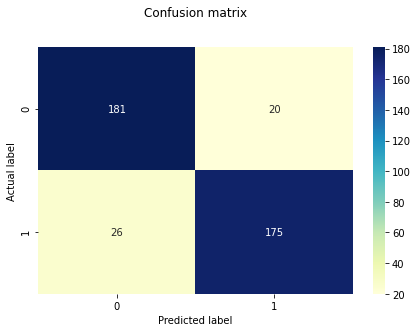

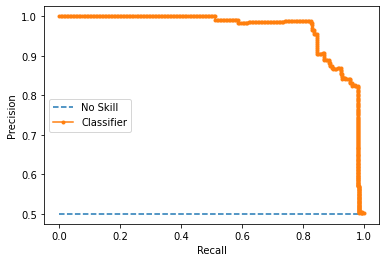

In [16]:
print("Y is binary: \n")
classify(df, 'binary', plotting=True)

## Test set: outcome has 5 classes

Y has 5 classes: 

Trait to predict:  openness
Number of authors in y_train:  1204
Number of authors in y_test:  402


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:78: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:86: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw


Number of authors in y_pred:  402
Names of the top 30 features: 
 MultiIndex([('subreddits',     'taylorswiftbum'),
            ('subreddits', 'takeonestepforward'),
            ('subreddits',           'carlisle'),
            ('subreddits',     'incelsgonewild'),
            ('subreddits',            'effexor'),
            ('subreddits',            'dessert'),
            ('subreddits', 'swiggityswootygifs'),
            ('subreddits',           'calmdown'),
            ('subreddits',        'kutreclames'),
            ('subreddits',            'scratch'),
            ('subreddits',          'zeldabotw'),
            ('subreddits', 'foundthemobileuser'),
            ('subreddits',          'fuckdruid'),
            ('subreddits',            'corolla'),
            ('subreddits',               'meat'),
            ('subreddits',                'sfx'),
            ('subreddits',              'motog'),
            ('subreddits',       'entrepreneur'),
            ('subreddits',   'yang

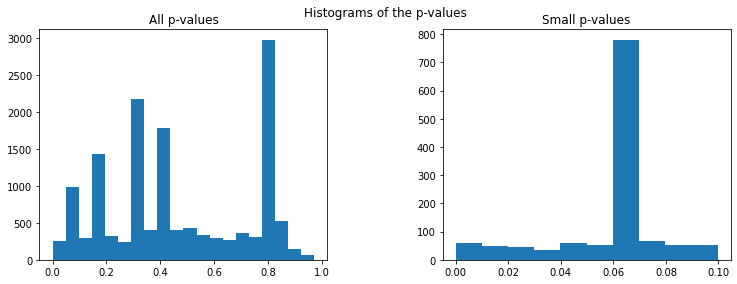

Number of features with this threshold:  111


Classification report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        43
           1       0.94      0.97      0.96        35
           2       0.97      0.97      0.97        66
           3       0.99      0.99      0.99       101
           4       1.00      0.99      1.00       157

    accuracy                           0.99       402
   macro avg       0.98      0.98      0.98       402
weighted avg       0.99      0.99      0.99       402

Trait to predict:  conscientiousness
Number of authors in y_train:  1204
Number of authors in y_test:  402


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:78: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:86: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw


Number of authors in y_pred:  402
Names of the top 30 features: 
 MultiIndex([(    'global',        'num_subreddit'),
            ('subreddits',      'formerpizzahuts'),
            ('subreddits',           'mbtidating'),
            ('subreddits',              'canning'),
            ('subreddits',           'wahoostipi'),
            ('subreddits',          'drydockporn'),
            ('subreddits',      'firstimpression'),
            ('subreddits',       'larrystylinson'),
            ('subreddits',       'warframerunway'),
            ('subreddits',                'iasip'),
            ('subreddits',  'newjerseyforsanders'),
            ('subreddits',  'psilocybinmushrooms'),
            ('subreddits',   'wholesomegreentext'),
            ('subreddits',                 'nova'),
            ('subreddits',     'garlicbreadmemes'),
            ('subreddits',                'chuck'),
            ('subreddits',          'cloververse'),
            ('subreddits',          'meandromeda')

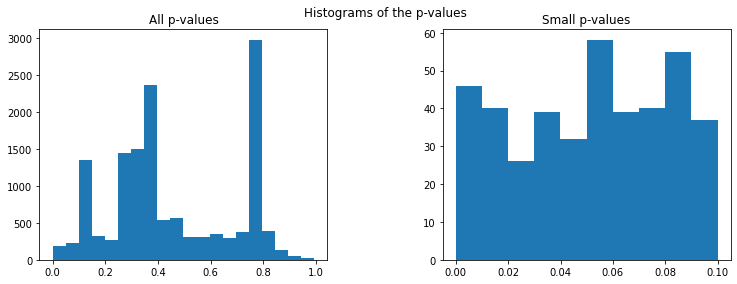

Number of features with this threshold:  280


Classification report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       144
           1       1.00      1.00      1.00        63
           2       0.99      0.96      0.97        80
           3       0.90      0.98      0.94        47
           4       1.00      0.97      0.99        68

    accuracy                           0.99       402
   macro avg       0.98      0.98      0.98       402
weighted avg       0.99      0.99      0.99       402

Trait to predict:  extraversion
Number of authors in y_train:  1204
Number of authors in y_test:  402


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:78: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:86: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw


Number of authors in y_pred:  402
Names of the top 30 features: 
 MultiIndex([('subreddits',         'startrekgifs'),
            ('subreddits',         'godlesswomen'),
            ('subreddits',    'shittylegaladvice'),
            ('subreddits',         'garlicmarket'),
            ('subreddits',              'newgirl'),
            ('subreddits',            'charlotte'),
            ('subreddits',             'birthday'),
            ('subreddits', 'cardsagainsthumanity'),
            ('subreddits',               'fetish'),
            ('subreddits',                 'mepl'),
            ('subreddits',         'christianr4r'),
            ('subreddits',   'completefreespeech'),
            ('subreddits',    'videogameanalysis'),
            ('subreddits',           'howyoudoin'),
            ('subreddits',            'mightyno9'),
            ('subreddits',                 'rift'),
            ('subreddits',         'pokemongodev'),
            ('subreddits',           'mommybully')

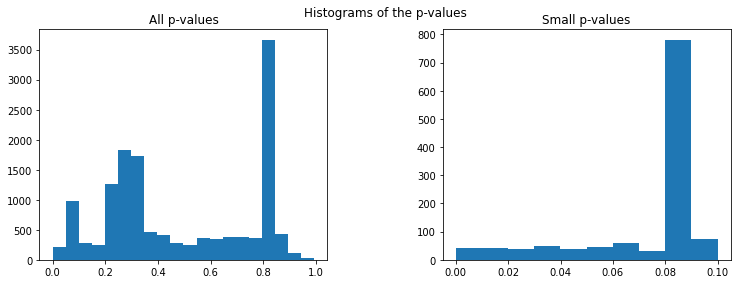

Number of features with this threshold:  208


Classification report: 
               precision    recall  f1-score   support

           0       1.00      0.99      0.99       168
           1       0.97      1.00      0.98        62
           2       0.99      0.96      0.97        73
           3       0.91      0.98      0.95        44
           4       1.00      0.98      0.99        55

    accuracy                           0.98       402
   macro avg       0.97      0.98      0.98       402
weighted avg       0.98      0.98      0.98       402

Trait to predict:  agreeableness
Number of authors in y_train:  1204
Number of authors in y_test:  402


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:78: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:86: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw


Number of authors in y_pred:  402
Names of the top 30 features: 
 MultiIndex([('subreddits',     'transitiongoals'),
            ('subreddits',        'treeofsavior'),
            ('subreddits',        'preformances'),
            ('subreddits',          'papgrappen'),
            ('subreddits',              'ethdev'),
            ('subreddits',        'christianr4r'),
            ('subreddits',           'slackline'),
            ('subreddits',     'eternalcardgame'),
            ('subreddits',            'sitecore'),
            ('subreddits',            'mathrock'),
            ('subreddits',              'seinen'),
            ('subreddits',        'donaldglover'),
            ('subreddits',         'u_wootyhoot'),
            ('subreddits',     'ironfistnetflix'),
            ('subreddits',          'archeology'),
            ('subreddits',         'neutralnews'),
            ('subreddits',        'youtubemusic'),
            ('subreddits',                'xbox'),
            ('su

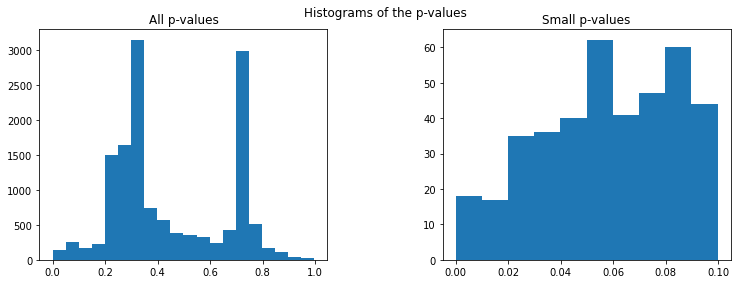

Number of features with this threshold:  106


Classification report: 
               precision    recall  f1-score   support

           0       1.00      0.98      0.99       138
           1       0.98      0.97      0.97        59
           2       0.96      0.99      0.97        69
           3       0.96      1.00      0.98        66
           4       1.00      0.99      0.99        70

    accuracy                           0.98       402
   macro avg       0.98      0.98      0.98       402
weighted avg       0.98      0.98      0.98       402

Trait to predict:  neuroticism
Number of authors in y_train:  1204
Number of authors in y_test:  402


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:78: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:86: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw


Number of authors in y_pred:  402
Names of the top 30 features: 
 MultiIndex([('subreddits',          'vinesauce'),
            ('subreddits',      'canadaclicker'),
            ('subreddits',          'modelcccp'),
            ('subreddits',         'animeitaly'),
            ('subreddits',           'roadporn'),
            ('subreddits',     'massquantities'),
            ('subreddits',      'shotglassbets'),
            ('subreddits',                'amd'),
            ('subreddits',               'soko'),
            ('subreddits',    'freecompliments'),
            ('subreddits',      'oliverfrancis'),
            ('subreddits',               'yale'),
            ('subreddits',        'tricitieswa'),
            ('subreddits',            'dueling'),
            ('subreddits', 'metacancersubdrama'),
            ('subreddits',              'bacon'),
            ('subreddits',   'imagesofthe1970s'),
            ('subreddits', 'thegreatwarchannel'),
            ('subreddits',        

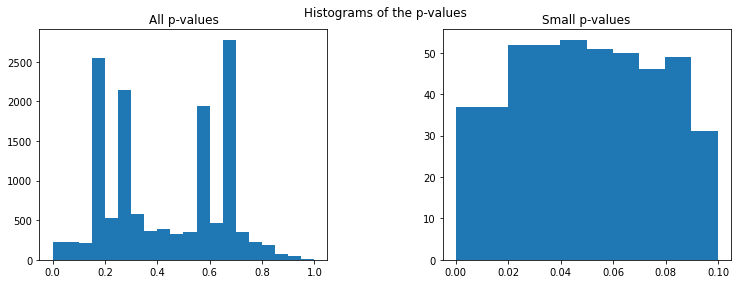

Number of features with this threshold:  178


Classification report: 
               precision    recall  f1-score   support

           0       0.99      0.98      0.99       101
           1       0.96      0.96      0.96        57
           2       0.96      0.97      0.97        75
           3       0.94      0.98      0.96        61
           4       1.00      0.97      0.99       108

    accuracy                           0.98       402
   macro avg       0.97      0.97      0.97       402
weighted avg       0.98      0.98      0.98       402



In [17]:
print("Y has 5 classes: \n")
classify(df, 'multi', plotting=True)

# Results of the train set

In [18]:
def classify_trainset(df, classes, plotting=True):
    startnumber = 18
    for trait_name in traits:
#         num_feat = switching(trait_name)
        num_feat = 30
        print("Trait to predict: ", trait_name)
        if classes == 'binary':
            x,y = trait(df, 'binary',trait_name, startnumber)
        else:
            x,y = trait(df, 'multi', trait_name, startnumber)
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=0)
        print("Number of authors in y_train: ", len(y_train))
        print("Number of authors in y_test: ", len(y_test))
        logpipe = create_pipeline(x_train, y_train, 'log', num_feat)
        y_pred=logpipe.predict(x_train)
        print("Number of authors in y_pred: ", len(y_pred))
        names = get_names(x, logpipe)
        print("Names of the top", len(names), "features: \n", names, "\n")
        pvalues = get_pvalues(logpipe, x)
    #     print("p-values of", len(pvalues), "features: \n", pvalues, "\n")
        if trait_name=="openness":
            count = pvalues['pvalue'].le(0.02).sum()
        if trait_name=="conscientiousness":
            count = pvalues['pvalue'].le(0.07).sum()
        if trait_name=="extraversion":
            count = pvalues['pvalue'].le(0.05).sum()
        if trait_name=="agreeableness":
            count = pvalues['pvalue'].le(0.04).sum()
        if trait_name=="neuroticism":
            count = pvalues['pvalue'].le(0.04).sum()
        print("Number of features with this threshold: ", count)
#         print("\nP-Values: \nNumber of features: ", 30)
#         print(pvalues.nsmallest(count,'pvalue'))
        print("\n")
        report = scores(y_train, y_pred, "report")
        print("Classification report: \n", report)
        if classes == 'binary':
            cnfmatrix = create_cnfmatrix(y_train, y_pred, plotting=True) 
    #     accuracy, precision, recall, f_one = scores(y_test, y_pred, "scores")
    #     print("Scores:\nAccuracy:",accuracy, "\nPrecision:",precision, "\nRecall:",recall, "\nF1 score:",f_one)
            lr_precision, lr_recall = score_plot(logpipe, y_train, x_train)
    #     print("Scores:\nLR_Precision:",lr_precision, "\nLR_Recall:",lr_recall)

## Train set: binary outcome

Classify trainset 
Y is binary: 

Trait to predict:  openness
Number of authors in y_train:  1204
Number of authors in y_test:  402


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:78: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:86: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


Number of authors in y_pred:  1204
Names of the top 30 features: 
 MultiIndex([('subreddits',      'taylorswiftbum'),
            ('subreddits',        'colonizemars'),
            ('subreddits',      'incelsgonewild'),
            ('subreddits',           'xsomalian'),
            ('subreddits',     'choose_your_own'),
            ('subreddits',            'calmdown'),
            ('subreddits',         'pharahmains'),
            ('subreddits',            'polyglot'),
            ('subreddits',             'scratch'),
            ('subreddits',              'techno'),
            ('subreddits',       'manyatruenerd'),
            ('subreddits',       'youshouldknow'),
            ('subreddits',          'pussymound'),
            ('subreddits',         'pipetobacco'),
            ('subreddits',    'perfect_response'),
            ('subreddits',            'winnipeg'),
            ('subreddits',           'nightwish'),
            ('subreddits', 'minecraftcirclejerk'),
            ('s

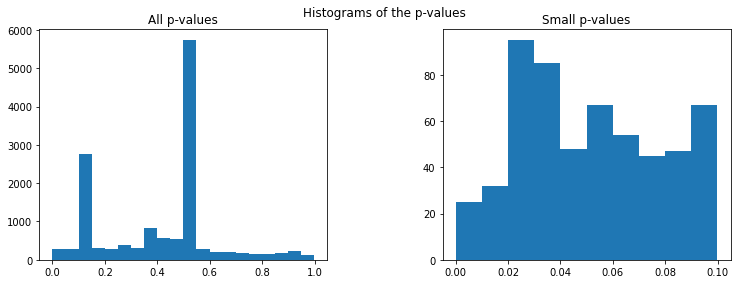

Number of features with this threshold:  57


Classification report: 
               precision    recall  f1-score   support

           0       0.99      0.85      0.92       355
           1       0.94      1.00      0.97       849

    accuracy                           0.96      1204
   macro avg       0.97      0.93      0.94      1204
weighted avg       0.96      0.96      0.95      1204

TN, FP, FN, TP:  303 52 2 847 
Sum:  1204 
Sum correct predictions:  1150 Percent:  0.9551495016611296 
Sum wrong predictions:  54 	Percent:  0.044850498338870434 
Sum actual positives:  849 	Percent:  0.7051495016611296 
Sum actual negatives:  355 	Percent:  0.29485049833887045


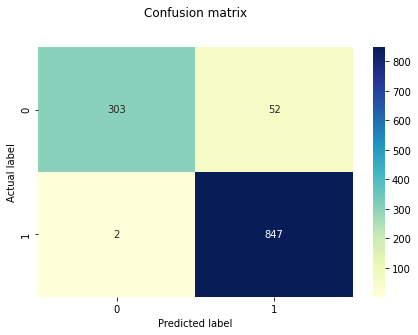

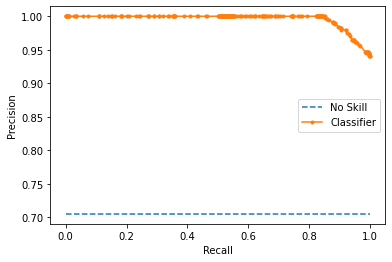

Trait to predict:  conscientiousness
Number of authors in y_train:  1204
Number of authors in y_test:  402


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:78: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:86: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


Number of authors in y_pred:  1204
Names of the top 30 features: 
 MultiIndex([(      'time',           'friday'),
            (      'time',            'march'),
            (      'time',             'june'),
            (      'time',         'november'),
            (      'time',             '2017'),
            ('subreddits',         'cyberdom'),
            ('subreddits',             'anno'),
            ('subreddits',       'astro_kpop'),
            ('subreddits',              'tfc'),
            ('subreddits',      'bimbofetish'),
            ('subreddits',            'ecchi'),
            ('subreddits',         'roadporn'),
            ('subreddits',        'roastmeta'),
            ('subreddits',   'warframerunway'),
            ('subreddits',             'nova'),
            ('subreddits',     'allthingsmlg'),
            ('subreddits',       'floridaman'),
            ('subreddits',    'oliverfrancis'),
            ('subreddits',            'motog'),
            ('subredd

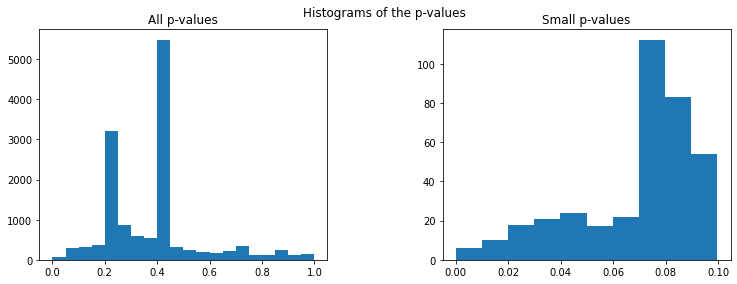

Number of features with this threshold:  118


Classification report: 
               precision    recall  f1-score   support

           0       0.92      0.97      0.94       746
           1       0.94      0.87      0.90       458

    accuracy                           0.93      1204
   macro avg       0.93      0.92      0.92      1204
weighted avg       0.93      0.93      0.93      1204

TN, FP, FN, TP:  720 26 60 398 
Sum:  1204 
Sum correct predictions:  1118 Percent:  0.9285714285714286 
Sum wrong predictions:  86 	Percent:  0.07142857142857142 
Sum actual positives:  458 	Percent:  0.3803986710963455 
Sum actual negatives:  746 	Percent:  0.6196013289036545


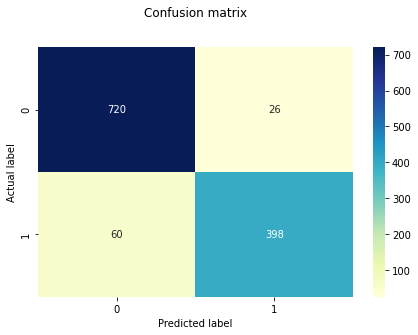

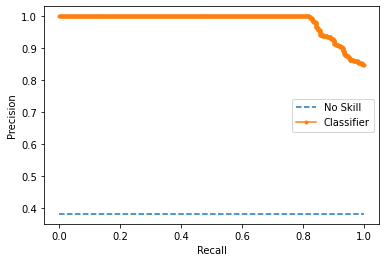

Trait to predict:  extraversion
Number of authors in y_train:  1204
Number of authors in y_test:  402


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:78: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:86: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


Number of authors in y_pred:  1204
Names of the top 30 features: 
 MultiIndex([('subreddits',             'aram'),
            ('subreddits',       'astro_kpop'),
            ('subreddits',      'politicsnow'),
            ('subreddits',      'goldenkamuy'),
            ('subreddits',  'theexaminedlife'),
            ('subreddits',          'newgirl'),
            ('subreddits',        'stretched'),
            ('subreddits',      'learncsharp'),
            ('subreddits',        'studioone'),
            ('subreddits',        'pokememes'),
            ('subreddits',   'bigtiddygothgf'),
            ('subreddits',             'mepl'),
            ('subreddits',     'christianr4r'),
            ('subreddits',      'ridiebridie'),
            ('subreddits',          'ableton'),
            ('subreddits',  'oopsdidntmeanto'),
            ('subreddits',            'motog'),
            ('subreddits',   'psych_religion'),
            ('subreddits',              'ubc'),
            ('subredd

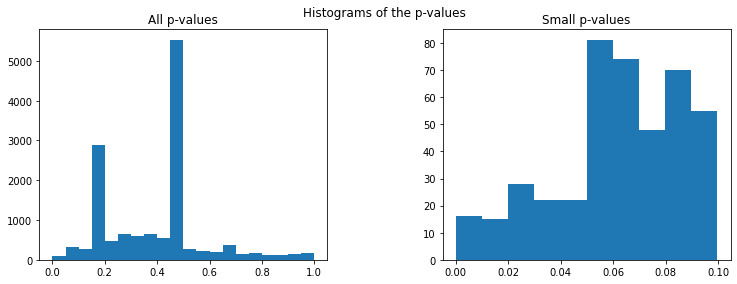

Number of features with this threshold:  104


Classification report: 
               precision    recall  f1-score   support

           0       0.96      0.95      0.95       779
           1       0.91      0.93      0.92       425

    accuracy                           0.94      1204
   macro avg       0.93      0.94      0.94      1204
weighted avg       0.94      0.94      0.94      1204

TN, FP, FN, TP:  740 39 31 394 
Sum:  1204 
Sum correct predictions:  1134 Percent:  0.9418604651162791 
Sum wrong predictions:  70 	Percent:  0.05813953488372093 
Sum actual positives:  425 	Percent:  0.35299003322259137 
Sum actual negatives:  779 	Percent:  0.6470099667774086


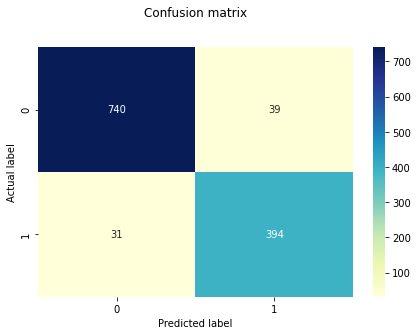

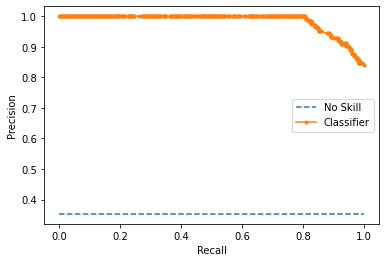

Trait to predict:  agreeableness
Number of authors in y_train:  1204
Number of authors in y_test:  402


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:78: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:86: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


Number of authors in y_pred:  1204
Names of the top 30 features: 
 MultiIndex([('subreddits',                'aram'),
            ('subreddits',        'xntxpolitics'),
            ('subreddits',       'healthanxiety'),
            ('subreddits',          'brainmemes'),
            ('subreddits',   'legendsoftomorrow'),
            ('subreddits',     'hmusfederalists'),
            ('subreddits',     'mhoclabourpress'),
            ('subreddits',                 'jhu'),
            ('subreddits',        'donaldglover'),
            ('subreddits',           'berlindnd'),
            ('subreddits',                'meup'),
            ('subreddits',     'notthebeaverton'),
            ('subreddits',     'ironfistnetflix'),
            ('subreddits',                'cern'),
            ('subreddits',            'celebsbr'),
            ('subreddits',                'beer'),
            ('subreddits',            'toukiden'),
            ('subreddits',        'youtubemusic'),
            ('s

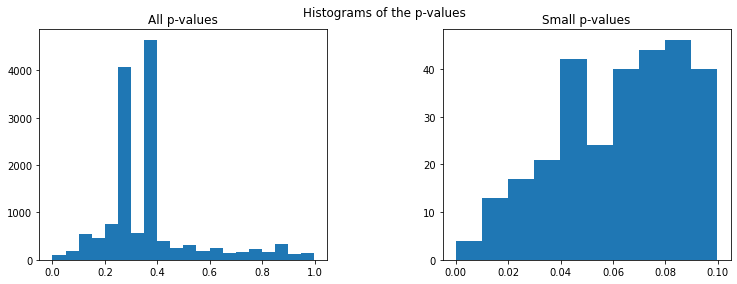

Number of features with this threshold:  55


Classification report: 
               precision    recall  f1-score   support

           0       1.00      0.91      0.95       680
           1       0.89      1.00      0.94       524

    accuracy                           0.95      1204
   macro avg       0.94      0.95      0.94      1204
weighted avg       0.95      0.95      0.95      1204

TN, FP, FN, TP:  616 64 2 522 
Sum:  1204 
Sum correct predictions:  1138 Percent:  0.9451827242524917 
Sum wrong predictions:  66 	Percent:  0.054817275747508304 
Sum actual positives:  524 	Percent:  0.43521594684385384 
Sum actual negatives:  680 	Percent:  0.5647840531561462


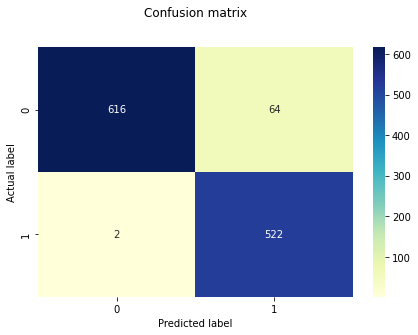

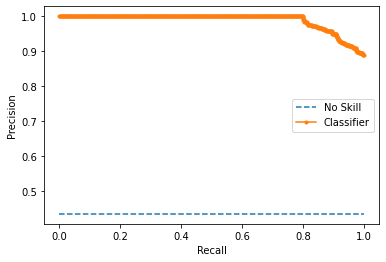

Trait to predict:  neuroticism
Number of authors in y_train:  1204
Number of authors in y_test:  402


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:78: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:86: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


Number of authors in y_pred:  1204
Names of the top 30 features: 
 MultiIndex([('subreddits',             'hammer'),
            ('subreddits',        'rightwinguk'),
            ('subreddits', 'smallpenisproblems'),
            ('subreddits',            'actuary'),
            ('subreddits',                'dae'),
            ('subreddits',                'm43'),
            ('subreddits',       'thegoodplace'),
            ('subreddits',                'gog'),
            ('subreddits',         'amumumains'),
            ('subreddits',    'mammothmountain'),
            ('subreddits',                'dsp'),
            ('subreddits',            'riseupp'),
            ('subreddits',              'bacon'),
            ('subreddits', 'thegreatwarchannel'),
            ('subreddits',            'iconsgg'),
            ('subreddits',  'writingcirclejerk'),
            ('subreddits', 'asianparentstories'),
            ('subreddits',      'pokemongonova'),
            ('subreddits',       

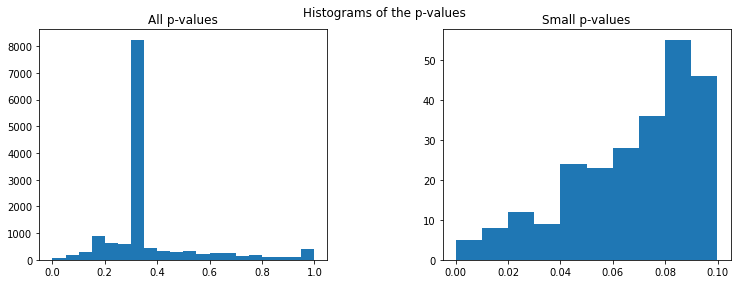

Number of features with this threshold:  35


Classification report: 
               precision    recall  f1-score   support

           0       0.93      0.94      0.94       592
           1       0.95      0.93      0.94       612

    accuracy                           0.94      1204
   macro avg       0.94      0.94      0.94      1204
weighted avg       0.94      0.94      0.94      1204

TN, FP, FN, TP:  559 33 41 571 
Sum:  1204 
Sum correct predictions:  1130 Percent:  0.9385382059800664 
Sum wrong predictions:  74 	Percent:  0.061461794019933555 
Sum actual positives:  612 	Percent:  0.5083056478405316 
Sum actual negatives:  592 	Percent:  0.49169435215946844


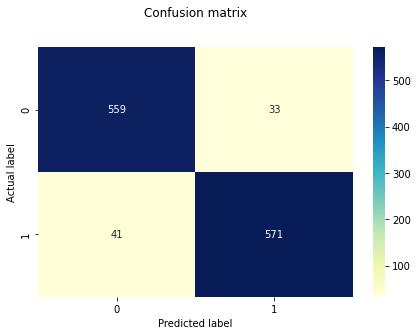

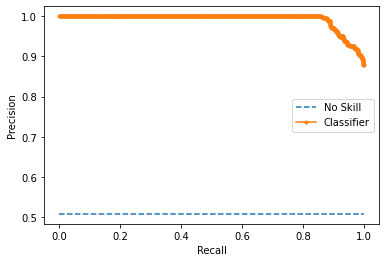

In [19]:
print("Classify trainset \nY is binary: \n")
classify_trainset(df, 'binary', plotting=True)

## Train set: outcome has 5 classes

Classify trainset 
Y has 5 classes: 

Trait to predict:  openness
Number of authors in y_train:  1204
Number of authors in y_test:  402


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:78: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:86: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw


Number of authors in y_pred:  1204
Names of the top 30 features: 
 MultiIndex([('subreddits',     'taylorswiftbum'),
            ('subreddits', 'takeonestepforward'),
            ('subreddits',           'carlisle'),
            ('subreddits',     'incelsgonewild'),
            ('subreddits',            'effexor'),
            ('subreddits',            'dessert'),
            ('subreddits', 'swiggityswootygifs'),
            ('subreddits',           'calmdown'),
            ('subreddits',        'kutreclames'),
            ('subreddits',            'scratch'),
            ('subreddits',          'zeldabotw'),
            ('subreddits', 'foundthemobileuser'),
            ('subreddits',          'fuckdruid'),
            ('subreddits',            'corolla'),
            ('subreddits',               'meat'),
            ('subreddits',                'sfx'),
            ('subreddits',              'motog'),
            ('subreddits',       'entrepreneur'),
            ('subreddits',   'yan

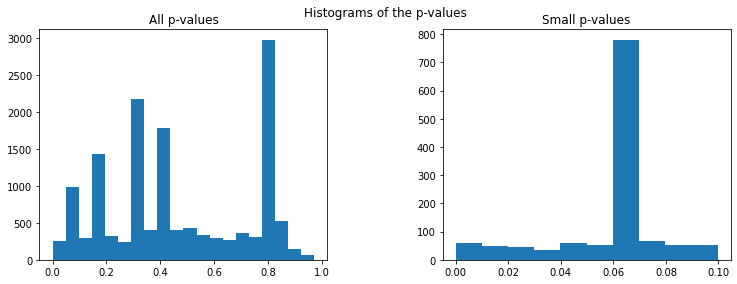

Number of features with this threshold:  111


Classification report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       158
           1       1.00      1.00      1.00       124
           2       1.00      1.00      1.00       205
           3       1.00      1.00      1.00       250
           4       1.00      1.00      1.00       467

    accuracy                           1.00      1204
   macro avg       1.00      1.00      1.00      1204
weighted avg       1.00      1.00      1.00      1204

Trait to predict:  conscientiousness
Number of authors in y_train:  1204
Number of authors in y_test:  402


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:78: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:86: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw


Number of authors in y_pred:  1204
Names of the top 30 features: 
 MultiIndex([(    'global',        'num_subreddit'),
            ('subreddits',      'formerpizzahuts'),
            ('subreddits',           'mbtidating'),
            ('subreddits',              'canning'),
            ('subreddits',           'wahoostipi'),
            ('subreddits',          'drydockporn'),
            ('subreddits',      'firstimpression'),
            ('subreddits',       'larrystylinson'),
            ('subreddits',       'warframerunway'),
            ('subreddits',                'iasip'),
            ('subreddits',  'newjerseyforsanders'),
            ('subreddits',  'psilocybinmushrooms'),
            ('subreddits',   'wholesomegreentext'),
            ('subreddits',                 'nova'),
            ('subreddits',     'garlicbreadmemes'),
            ('subreddits',                'chuck'),
            ('subreddits',          'cloververse'),
            ('subreddits',          'meandromeda'

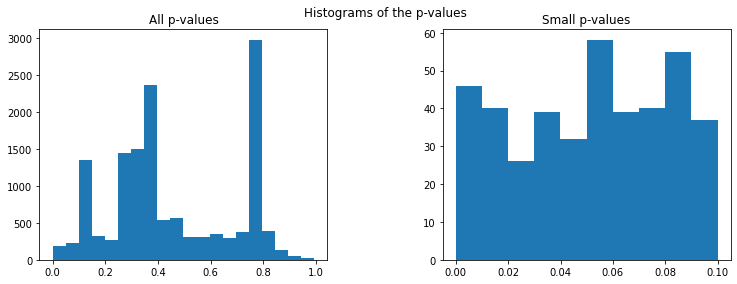

Number of features with this threshold:  280


Classification report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       416
           1       1.00      1.00      1.00       236
           2       1.00      1.00      1.00       196
           3       1.00      1.00      1.00       145
           4       1.00      1.00      1.00       211

    accuracy                           1.00      1204
   macro avg       1.00      1.00      1.00      1204
weighted avg       1.00      1.00      1.00      1204

Trait to predict:  extraversion
Number of authors in y_train:  1204
Number of authors in y_test:  402


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:78: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:86: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw


Number of authors in y_pred:  1204
Names of the top 30 features: 
 MultiIndex([('subreddits',         'startrekgifs'),
            ('subreddits',         'godlesswomen'),
            ('subreddits',    'shittylegaladvice'),
            ('subreddits',         'garlicmarket'),
            ('subreddits',              'newgirl'),
            ('subreddits',            'charlotte'),
            ('subreddits',             'birthday'),
            ('subreddits', 'cardsagainsthumanity'),
            ('subreddits',               'fetish'),
            ('subreddits',                 'mepl'),
            ('subreddits',         'christianr4r'),
            ('subreddits',   'completefreespeech'),
            ('subreddits',    'videogameanalysis'),
            ('subreddits',           'howyoudoin'),
            ('subreddits',            'mightyno9'),
            ('subreddits',                 'rift'),
            ('subreddits',         'pokemongodev'),
            ('subreddits',           'mommybully'

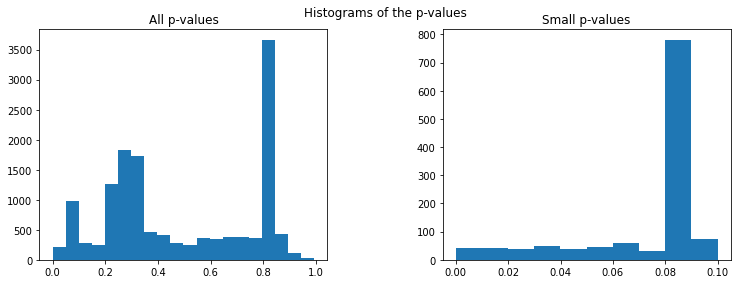

Number of features with this threshold:  208


Classification report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       477
           1       1.00      1.00      1.00       219
           2       1.00      1.00      1.00       193
           3       1.00      1.00      1.00       132
           4       1.00      1.00      1.00       183

    accuracy                           1.00      1204
   macro avg       1.00      1.00      1.00      1204
weighted avg       1.00      1.00      1.00      1204

Trait to predict:  agreeableness
Number of authors in y_train:  1204
Number of authors in y_test:  402


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:78: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:86: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw


Number of authors in y_pred:  1204
Names of the top 30 features: 
 MultiIndex([('subreddits',     'transitiongoals'),
            ('subreddits',        'treeofsavior'),
            ('subreddits',        'preformances'),
            ('subreddits',          'papgrappen'),
            ('subreddits',              'ethdev'),
            ('subreddits',        'christianr4r'),
            ('subreddits',           'slackline'),
            ('subreddits',     'eternalcardgame'),
            ('subreddits',            'sitecore'),
            ('subreddits',            'mathrock'),
            ('subreddits',              'seinen'),
            ('subreddits',        'donaldglover'),
            ('subreddits',         'u_wootyhoot'),
            ('subreddits',     'ironfistnetflix'),
            ('subreddits',          'archeology'),
            ('subreddits',         'neutralnews'),
            ('subreddits',        'youtubemusic'),
            ('subreddits',                'xbox'),
            ('s

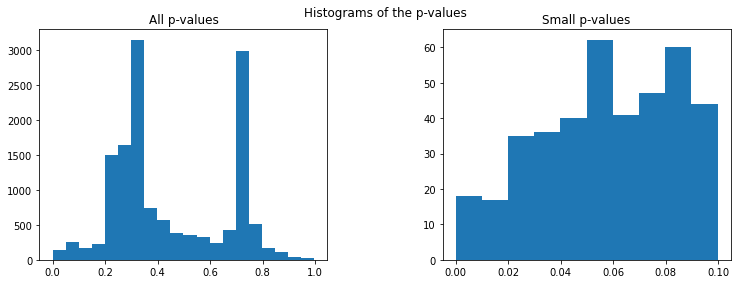

Number of features with this threshold:  106


Classification report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       394
           1       1.00      1.00      1.00       211
           2       1.00      1.00      1.00       204
           3       1.00      1.00      1.00       181
           4       1.00      1.00      1.00       214

    accuracy                           1.00      1204
   macro avg       1.00      1.00      1.00      1204
weighted avg       1.00      1.00      1.00      1204

Trait to predict:  neuroticism
Number of authors in y_train:  1204
Number of authors in y_test:  402


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:78: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:86: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw


Number of authors in y_pred:  1204
Names of the top 30 features: 
 MultiIndex([('subreddits',          'vinesauce'),
            ('subreddits',      'canadaclicker'),
            ('subreddits',          'modelcccp'),
            ('subreddits',         'animeitaly'),
            ('subreddits',           'roadporn'),
            ('subreddits',     'massquantities'),
            ('subreddits',      'shotglassbets'),
            ('subreddits',                'amd'),
            ('subreddits',               'soko'),
            ('subreddits',    'freecompliments'),
            ('subreddits',      'oliverfrancis'),
            ('subreddits',               'yale'),
            ('subreddits',        'tricitieswa'),
            ('subreddits',            'dueling'),
            ('subreddits', 'metacancersubdrama'),
            ('subreddits',              'bacon'),
            ('subreddits',   'imagesofthe1970s'),
            ('subreddits', 'thegreatwarchannel'),
            ('subreddits',       

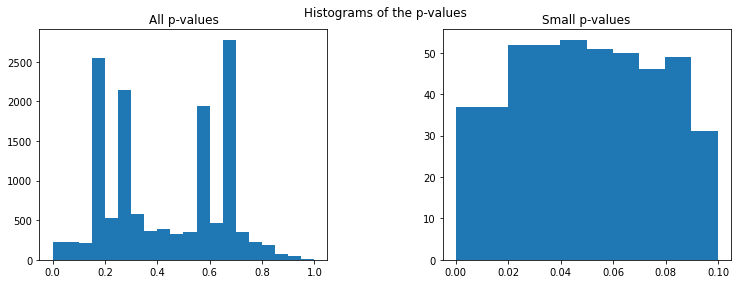

Number of features with this threshold:  178


Classification report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       317
           1       1.00      1.00      1.00       172
           2       1.00      1.00      1.00       198
           3       1.00      1.00      1.00       169
           4       1.00      1.00      1.00       348

    accuracy                           1.00      1204
   macro avg       1.00      1.00      1.00      1204
weighted avg       1.00      1.00      1.00      1204



In [20]:
print("Classify trainset \nY has 5 classes: \n")
classify_trainset(df, 'multi', plotting=True)